#------------STARTING POINT---------------

In [13]:
# !pip install --upgrade sagemaker

In [34]:
!pip show  sagemaker

Name: sagemaker
Version: 2.39.0
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: None
License: Apache License 2.0
Location: /usr/local/lib/python3.7/site-packages
Requires: attrs, boto3, google-pasta, numpy, protobuf, protobuf3-to-dict, smdebug-rulesconfig, importlib-metadata, packaging, pandas, pathos
Required-by: 


# Data Prep 

# Prepare Data
## Train Dataset

In [35]:
import itertools
import boto3

# Download and process the Open Images annotations
!wget https://storage.googleapis.com/openimages/2018_04/test/test-annotations-human-imagelabels-boxable.csv -O openimgs-annotations.csv
with open('openimgs-annotations.csv', 'r') as f:
    all_labels = [line.strip().split(',') for line in f.readlines()]
    
 # Extract image ids in each of our desired classes
ims = {}
ims['Truck'] = [label[0] for label in all_labels if (label[2] == '/m/07r04' and label[3] == '1')][:5]
ims['Limousine'] = [label[0] for label in all_labels if (label[2] == '/m/01lcw4' and label[3] == '1')][:5]
ims['Van'] = [label[0] for label in all_labels if (label[2] == '/m/0h2r6' and label[3] == '1')][:5]
ims['Car'] = [label[0] for label in all_labels if (label[2] == '/m/0pg52' and label[3] == '1')][:5]
ims['Motorcycle'] = [label[0] for label in all_labels if (label[2] == '/m/04_sv' and label[3] == '1')][:5]
num_classes = len(ims)


--2021-06-19 15:56:53--  https://storage.googleapis.com/openimages/2018_04/test/test-annotations-human-imagelabels-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 172.217.164.176, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26460276 (25M) [text/csv]
Saving to: ‘openimgs-annotations.csv’

openimgs-annotation 100%[===================>]  25.23M   108MB/s    in 0.2s    

2021-06-19 15:56:53 (108 MB/s) - ‘openimgs-annotations.csv’ saved [26460276/26460276]



In [90]:
CLASS_LIST = list(['Car', 'Bike','Van','Truck','Limousine'])
print("Label space is {}".format(CLASS_LIST))


Label space is ['Car', 'Bike', 'Van', 'Truck', 'Limousine']


In [3]:
for key in ims.keys():
    ims[key] = set(ims[key])

ims.keys()

dict_keys(['Truck', 'Limousine', 'Van', 'Car', 'Motorcycle'])

In [8]:
ims.values()

dict_values([['02b0da8ba5299b0a', '02b95c28d9fffd9c', '02ef4c2638e29d60', '03014954973d3eb7', '03092ceeef16cb24'], ['1c9a5b9c3cf42d03', '1ed9e75377a13e76', '2cba1672bca71ece', '33c7169f6c220128', '37dd94623bc33e92'], ['03ec0d6ccfa8c3cd', '045cffd17afd6f71', '04c455547d1a0b3f', '04d0c65af7de20ff', '050f8154acb0fe82'], ['14c081814f992962', '16af9a24ba435d23', '23bf738cb05aeca8', '2de8c95c6655a3ac', '361270ef3ae65e3a'], ['042676f6b5eba097', '062261a4ce80965e', '0745beb7a3b3d4e3', '08a67848b41f0511', '08eb9697d767c481']])

In [9]:
ims['Truck']

['02b0da8ba5299b0a',
 '02b95c28d9fffd9c',
 '02ef4c2638e29d60',
 '03014954973d3eb7',
 '03092ceeef16cb24']

In [15]:
for k in ims.keys():
    for v in ims[k]:
        print('aws s3 cp s3://open-images-dataset/test/{}.jpg ./dataset/vehicles/train/{}/{}.jpg'.format(v,k,v))

aws s3 cp s3://open-images-dataset/test/02b0da8ba5299b0a.jpg ./dataset/vehicles/train/Truck/02b0da8ba5299b0a.jpg
aws s3 cp s3://open-images-dataset/test/02b95c28d9fffd9c.jpg ./dataset/vehicles/train/Truck/02b95c28d9fffd9c.jpg
aws s3 cp s3://open-images-dataset/test/02ef4c2638e29d60.jpg ./dataset/vehicles/train/Truck/02ef4c2638e29d60.jpg
aws s3 cp s3://open-images-dataset/test/03014954973d3eb7.jpg ./dataset/vehicles/train/Truck/03014954973d3eb7.jpg
aws s3 cp s3://open-images-dataset/test/03092ceeef16cb24.jpg ./dataset/vehicles/train/Truck/03092ceeef16cb24.jpg
aws s3 cp s3://open-images-dataset/test/1c9a5b9c3cf42d03.jpg ./dataset/vehicles/train/Limousine/1c9a5b9c3cf42d03.jpg
aws s3 cp s3://open-images-dataset/test/1ed9e75377a13e76.jpg ./dataset/vehicles/train/Limousine/1ed9e75377a13e76.jpg
aws s3 cp s3://open-images-dataset/test/2cba1672bca71ece.jpg ./dataset/vehicles/train/Limousine/2cba1672bca71ece.jpg
aws s3 cp s3://open-images-dataset/test/33c7169f6c220128.jpg ./dataset/vehicles/trai

## Validation Dataset

In [7]:
 # Extract image ids in each of our desired classes
ims = {}
ims['Truck'] = [label[0] for label in all_labels if (label[2] == '/m/07r04' and label[3] == '1')][6:11]
ims['Limousine'] = [label[0] for label in all_labels if (label[2] == '/m/01lcw4' and label[3] == '1')][6:11]
ims['Van'] = [label[0] for label in all_labels if (label[2] == '/m/0h2r6' and label[3] == '1')][6:11]
ims['Car'] = [label[0] for label in all_labels if (label[2] == '/m/0pg52' and label[3] == '1')][6:11]
ims['Motorcycle'] = [label[0] for label in all_labels if (label[2] == '/m/04_sv' and label[3] == '1')][6:11]
num_classes = len(ims)

In [10]:
for k in ims.keys():
    for v in ims[k]:
        print('aws s3 cp s3://open-images-dataset/test/{}.jpg ./dataset/vehicles/val/{}/{}.jpg'.format(v,k,v))

aws s3 cp s3://open-images-dataset/test/02b0da8ba5299b0a.jpg ./dataset/vehicles/val/Truck/02b0da8ba5299b0a.jpg
aws s3 cp s3://open-images-dataset/test/02b95c28d9fffd9c.jpg ./dataset/vehicles/val/Truck/02b95c28d9fffd9c.jpg
aws s3 cp s3://open-images-dataset/test/02ef4c2638e29d60.jpg ./dataset/vehicles/val/Truck/02ef4c2638e29d60.jpg
aws s3 cp s3://open-images-dataset/test/03014954973d3eb7.jpg ./dataset/vehicles/val/Truck/03014954973d3eb7.jpg
aws s3 cp s3://open-images-dataset/test/03092ceeef16cb24.jpg ./dataset/vehicles/val/Truck/03092ceeef16cb24.jpg
aws s3 cp s3://open-images-dataset/test/1c9a5b9c3cf42d03.jpg ./dataset/vehicles/val/Limousine/1c9a5b9c3cf42d03.jpg
aws s3 cp s3://open-images-dataset/test/1ed9e75377a13e76.jpg ./dataset/vehicles/val/Limousine/1ed9e75377a13e76.jpg
aws s3 cp s3://open-images-dataset/test/2cba1672bca71ece.jpg ./dataset/vehicles/val/Limousine/2cba1672bca71ece.jpg
aws s3 cp s3://open-images-dataset/test/33c7169f6c220128.jpg ./dataset/vehicles/val/Limousine/33c716

In [36]:
%%time
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import os 
import urllib.request


role = get_execution_role()
bucket = "prj-ml"

def upload_to_s3(channel, Path):
    s3_path_to_data = sagemaker.Session().upload_data(bucket=bucket, 
                                                  path=Path, 
                                                  key_prefix=channel)
# data copy to s3
s3_train_key = "tyt-5vehicle-scriptmode/train"
s3_validation_key = "tyt-5vehicle-scriptmode/validation"
s3_train = 's3://{}/{}/'.format(bucket, s3_train_key)
s3_validation = 's3://{}/{}/'.format(bucket, s3_validation_key)


upload_to_s3(s3_train_key, './dataset/vehicles/train/')

upload_to_s3(s3_validation_key, './dataset/vehicles/val/')


CPU times: user 634 ms, sys: 72.6 ms, total: 706 ms
Wall time: 5.64 s


In [37]:
import os
import sagemaker
from sagemaker.tensorflow import TensorFlow

In [38]:
ON_SAGEMAKER_NOTEBOOK = True

sagemaker_session = sagemaker.Session()
if ON_SAGEMAKER_NOTEBOOK:
    role = sagemaker.get_execution_role()
else:
    role = "[YOUR ROLE]"


bucket = "prj-ml"
key = "tyt-5vehicle-scriptmode"
key_output = "output"                   # Path from the bucket's root to the dataset
# train_instance_type='ml.m5.large'      # The type of EC2 instance which will be used for training
# deploy_instance_type='ml.m5.large'     # The type of EC2 instance which will be used for deployment
hyperparameters={
    "learning_rate": 1e-4,
    "decay": 1e-6
}

# train_use_spot_instances=True
# train_max_run=3600
# train_max_wait = 3600 if train_use_spot_instances else None

train_input_path = "s3://{}/{}/train/".format(bucket, key)
validation_input_path = "s3://{}/{}/validation/".format(bucket, key)
train_input_path, validation_input_path

('s3://prj-ml/tyt-5vehicle-scriptmode/train/',
 's3://prj-ml/tyt-5vehicle-scriptmode/validation/')

# Local Test

In [39]:
import argparse, os
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [40]:
# epochs     = args.epochs
# lr         = args.learning_rate
# batch_size = args.batch_size
# gpu_count  = args.gpu_count
# model_dir  = args.model_dir
training_dir   = './dataset/vehicles/train/'
validation_dir = './dataset/vehicles/val/'
num_classes = 5
image_resize = 150
batch_size_training = 4
batch_size_validation = 4
data_generator = ImageDataGenerator(
preprocessing_function=preprocess_input,
)

print('HBA>> Preprosessing Data with data_generator:')


train_generator = data_generator.flow_from_directory(
training_dir,
target_size=(image_resize, image_resize),
batch_size=batch_size_training,
class_mode='categorical')

## and another one for the validation set.


validation_generator = data_generator.flow_from_directory(
validation_dir,
target_size=(image_resize, image_resize),
batch_size=batch_size_validation,
class_mode='categorical')



HBA>> Preprosessing Data with data_generator:
Found 26 images belonging to 5 classes.
Found 26 images belonging to 5 classes.


In [19]:
print('HBA>> Initializing model: ResNet50:')

# Initialising Model
model = Sequential()
model.add(ResNet50(
        include_top=False,
        pooling='avg',
        weights='imagenet',
        ))
# Output layer
model.add(Dense(num_classes, activation='softmax'))
model.layers[0].trainable = False

print(model.summary())        


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# steps_per_epoch_training = len(train_generator)
# steps_per_epoch_validation = len(validation_generator)



HBA>> Initializing model: ResNet50:
[2021-06-19 15:06:16.871 tensorflow-2-3-cpu-py-ml-t3-medium-dbca98283d57d615662c4efa28c8:1066 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-06-19 15:06:17.115 tensorflow-2-3-cpu-py-ml-t3-medium-dbca98283d57d615662c4efa28c8:1066 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
94773248/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [20]:
num_epochs = 10

fit_history = model.fit_generator(
                    train_generator,
                    # steps_per_epoch=steps_per_epoch_training,
                    epochs=num_epochs,
                    validation_data=validation_generator,
                    # validation_steps=steps_per_epoch_validation,
                    verbose=1,
                    )

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/10
7/7 [==============================] - 5s 763ms/step - loss: 2.5680 - accuracy: 0.2308 - val_loss: 1.8243 - val_accuracy: 0.3077
Epoch 2/10
7/7 [==============================] - 3s 460ms/step - loss: 1.1453 - accuracy: 0.5385 - val_loss: 1.5559 - val_accuracy: 0.3846
Epoch 3/10
7/7 [==============================] - 3s 455ms/step - loss: 0.5225 - accuracy: 0.7308 - val_loss: 1.1785 - val_accuracy: 0.4615
Epoch 4/10
7/7 [==============================] - 3s 488ms/step - loss: 0.2645 - accuracy: 0.9231 - val_loss: 1.0529 - val_accuracy: 0.6538
Epoch 5/10
7/7 [==============================] - 3s 457ms/step - loss: 0.1136 - accuracy: 1.0000 - val_loss: 0.9591 - val_accuracy: 0.6923
Epoch 6/10
7/7 [==============================] - 3s 462ms/step - loss: 0.0580 - accuracy: 1.0000 - val_loss: 0.9104 - val_accuracy: 0.7308
Epoch 7/10
7/7 [==============================] - 3s 475ms/step - loss: 0.0374 - accuracy: 1.0000 - val_loss: 0.8886 - val_accuracy: 0.6923
Epoch 8/10
7/7 [====

In [24]:
print('HBA>> Evaluating Model')

#score = model.evaluate(x_val, y_val, verbose=0)
score=model.evaluate_generator(validation_generator, steps=1, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
print('Validation loss    :', score[0])
print('Validation accuracy:', score[1])




HBA>> Evaluating Model
Validation loss    : 1.4640601873397827
Validation accuracy: 0.25


### TF1 Save
hba: see https://stackoverflow.com/a/58442121/11127923

In [28]:

# import tensorflow.python.keras.backend as K
# sess = K.get_session()

# # save Keras model for Tensorflow Serving
# # sess = K.get_session()

# tf.saved_model.simple_save(
#     sess,
#     os.path.join(model_dir, 'model/1'),
#     inputs={'inputs': model.input},
#     outputs={t.name: t for t in model.outputs})

### TF2 Save

In [23]:
model.save('output/model_tty_vehicle_classifier')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: output/model_tty_vehicle_classifier/assets


INFO:tensorflow:Assets written to: output/model_tty_vehicle_classifier/assets


In [30]:
model.save('output/model_tty_vehicle_classifier.h5')

# SageMaker Experiments

In [50]:
!pip install sagemaker-experiments

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [53]:
from time import strftime, gmtime

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [56]:
sess = sagemaker.session.Session()

create_date = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
experiment = Experiment.create(
    experiment_name="tyt-5vehicle-scriptm-{}".format(create_date),
    description="Vehicle Classification DL, TF/Keras, resNet",
    sagemaker_boto_client=boto3.client("sagemaker"),
)


In [57]:

trial = Trial.create(
    trial_name="runtf2-{}".format(strftime("%Y-%m-%d-%H-%M-%S", gmtime())),
    experiment_name=experiment.experiment_name,
    sagemaker_boto_client=boto3.client("sagemaker"),
)


# SageMaker Training

In [61]:
estimator = TensorFlow(
  entry_point="run-training-tf2.py",             # Your entry script
  role=role,
#   framework_version="1.14.0",               # TensorFlow's version
  framework_version="2.2",               # TensorFlow's version
#   framework_version="2.1",               # TensorFlow's version
  hyperparameters=hyperparameters,
  training_steps=10,
  evaluation_steps=10,
  instance_count=1,                   # "The number of GPUs instances to use"
  instance_type='ml.m5.large',
    #   use_spot_instances=train_use_spot_instances,  
#   max_run=train_max_run,
#   max_wait=train_max_wait,
  py_version="py37",  # now required    
#   py_version="py3",  # now required    
)

print("Training ...")
estimator.fit({'training': train_input_path, 'validation': validation_input_path},
                 experiment_config={
        "ExperimentName": experiment.experiment_name,
        "TrialName": trial.trial_name,
        "TrialComponentDisplayName": trial.trial_name,
    },
    wait=False
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Training ...


INFO:sagemaker:Creating training-job with name: tensorflow-training-2021-06-19-17-52-38-971


2021-06-19 17:52:39 Starting - Starting the training job...
2021-06-19 17:53:04 Starting - Launching requested ML instancesProfilerReport-1624125159: InProgress
...
2021-06-19 17:53:39 Starting - Preparing the instances for training.........
2021-06-19 17:55:05 Downloading - Downloading input data...
2021-06-19 17:55:29 Training - Downloading the training image..2021-06-19 17:55:46.175264: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:425] Initializing the SageMaker Profiler.
2021-06-19 17:55:46.179864: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:106] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-06-19 17:55:46.335789: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:425] Initializing the SageMaker Profiler.
2021-06-19 17:55:50,095 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-06-19 17:55:50,103 sagemaker-training-

In [68]:
print("Deploying ...")
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large',
                            wait = False)

print("Predictor endpoint name : %s" % predictor.endpoint)


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating model with name: tensorflow-training-2021-06-19-18-12-13-408


Deploying ...


INFO:sagemaker:Creating endpoint with name tensorflow-training-2021-06-19-18-12-13-408
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Predictor endpoint name : tensorflow-training-2021-06-19-18-12-13-408


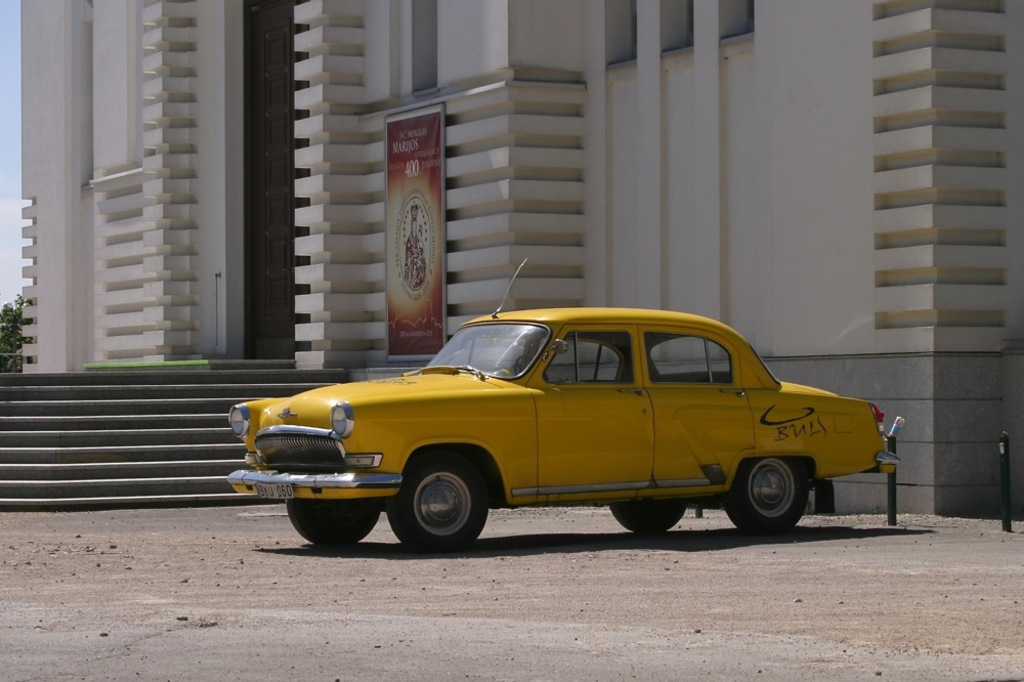

In [63]:
import numpy as np
from sagemaker.tensorflow.serving import Predictor
from tensorflow.python.keras.preprocessing.image import load_img

# !wget -O /tmp/test.jpg https://YOURPath.jpeg
file_name = './car10050ae3c7122b14.jpg'

# test image
from IPython.display import Image
Image(file_name)


## Predict w/ boto??

In [ ]:

sagemaker_boto_runtime = boto3.client('sagemaker-runtime')

endpoint_name = "tensorflow-training-2021-06-19-17-59-07-114"                                       # Your endpoint name.
response = sagemaker_boto_runtime.invoke_endpoint(
    EndpointName=endpoint_name, 
    Body=test_image_array
    )

## Predict chest-XRAY, not working

In [72]:
# Resize as model was trained after resizing
test_image = load_img(file_name, target_size=(150, 150))
test_image_array = np.array(test_image).reshape((1, 150, 150, 3)).tolist()



In [ ]:
# Predict
# pred2 = Predictor(endpoint_name = 'tensorflow-training-2021-06-19-17-59-07-114')
pred2 = Predictor(endpoint_name = 'tensorflow-training-2021-06-19-18-12-13-408')
print(predictor.predict({"instances": [{"inputs": test_image_array}]}))


## ResNet SageM Example - WORKING WORKING WORKING !!!
 https://answers.amazon.com/posts/106059

In [77]:
# create a TFModel and deploy (Based on the SageMaker documentation:
from sagemaker.tensorflow.serving import Model

model3 = Model(model_data='s3://sagemaker-us-east-1-123456789012/tensorflow-training-2021-06-19-17-52-38-971/output/model.tar.gz', 
              role='arn:aws:iam::123456789012:role/service-role/AmazonSageMaker-ExecutionRole-20180314T175147', 
              framework_version='2.0.0')

pred3 = model3.deploy(initial_instance_count=1, instance_type='ml.m5.large',
                    wait = False)



See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating model with name: tensorflow-inference-2021-06-19-18-50-54-402
INFO:sagemaker:Creating endpoint with name tensorflow-inference-2021-06-19-18-50-54-724


In [88]:
# Run preprocessing + send the data to the endpoint:
input_shape = (224, 224, 3)
img3 = tf.keras.preprocessing.image.load_img(file_name, target_size=(input_shape[0], input_shape[1]))

# convert image to numpy array
img_array3 = tf.keras.preprocessing.image.img_to_array(img3)

# the image is now in an array of shape (3, 224, 224)
# need to expand it to (1, 3, 224, 224) as it's expecting a list

expanded_img_array3 = np.expand_dims(img_array3, axis=0)
preprocessed_img3 = preprocess_input(expanded_img_array3)


In [89]:
# extract the features
features3 = pred3.predict(preprocessed_img3)['predictions'][0]
features3

[0.919815, 0.0170698706, 0.00404436281, 0.0165052265, 0.0425655134]

In [94]:
print("Model prediction is: {}".format(CLASS_LIST[np.argmax(features3)]))

Model prediction is: Car


## Predict 4 - Vehicle - Not Working: Unsupported Media Type: application/x-image

In [ ]:
# with open("test_inputs/{}".format(test_images[0]), "rb") as f:
with open(file_name, "rb") as f:
    payload4 = f.read()
    payload4 = bytearray(payload4)

response4 = sagemaker_boto_runtime.invoke_endpoint(
    EndpointName='tensorflow-inference-2021-06-19-18-50-54-724', 
    ContentType="application/x-image", Body=payload4
)    

# `response` comes in a json format, let's unpack it.
result4 = json.loads(response4["Body"].read())
# The result outputs the probabilities for all classes.
# Find the class with maximum probability and print the class name.
print("Model prediction is: {}".format(CLASS_LIST[np.argmax(result4)]))

# APPENDIX - BULK

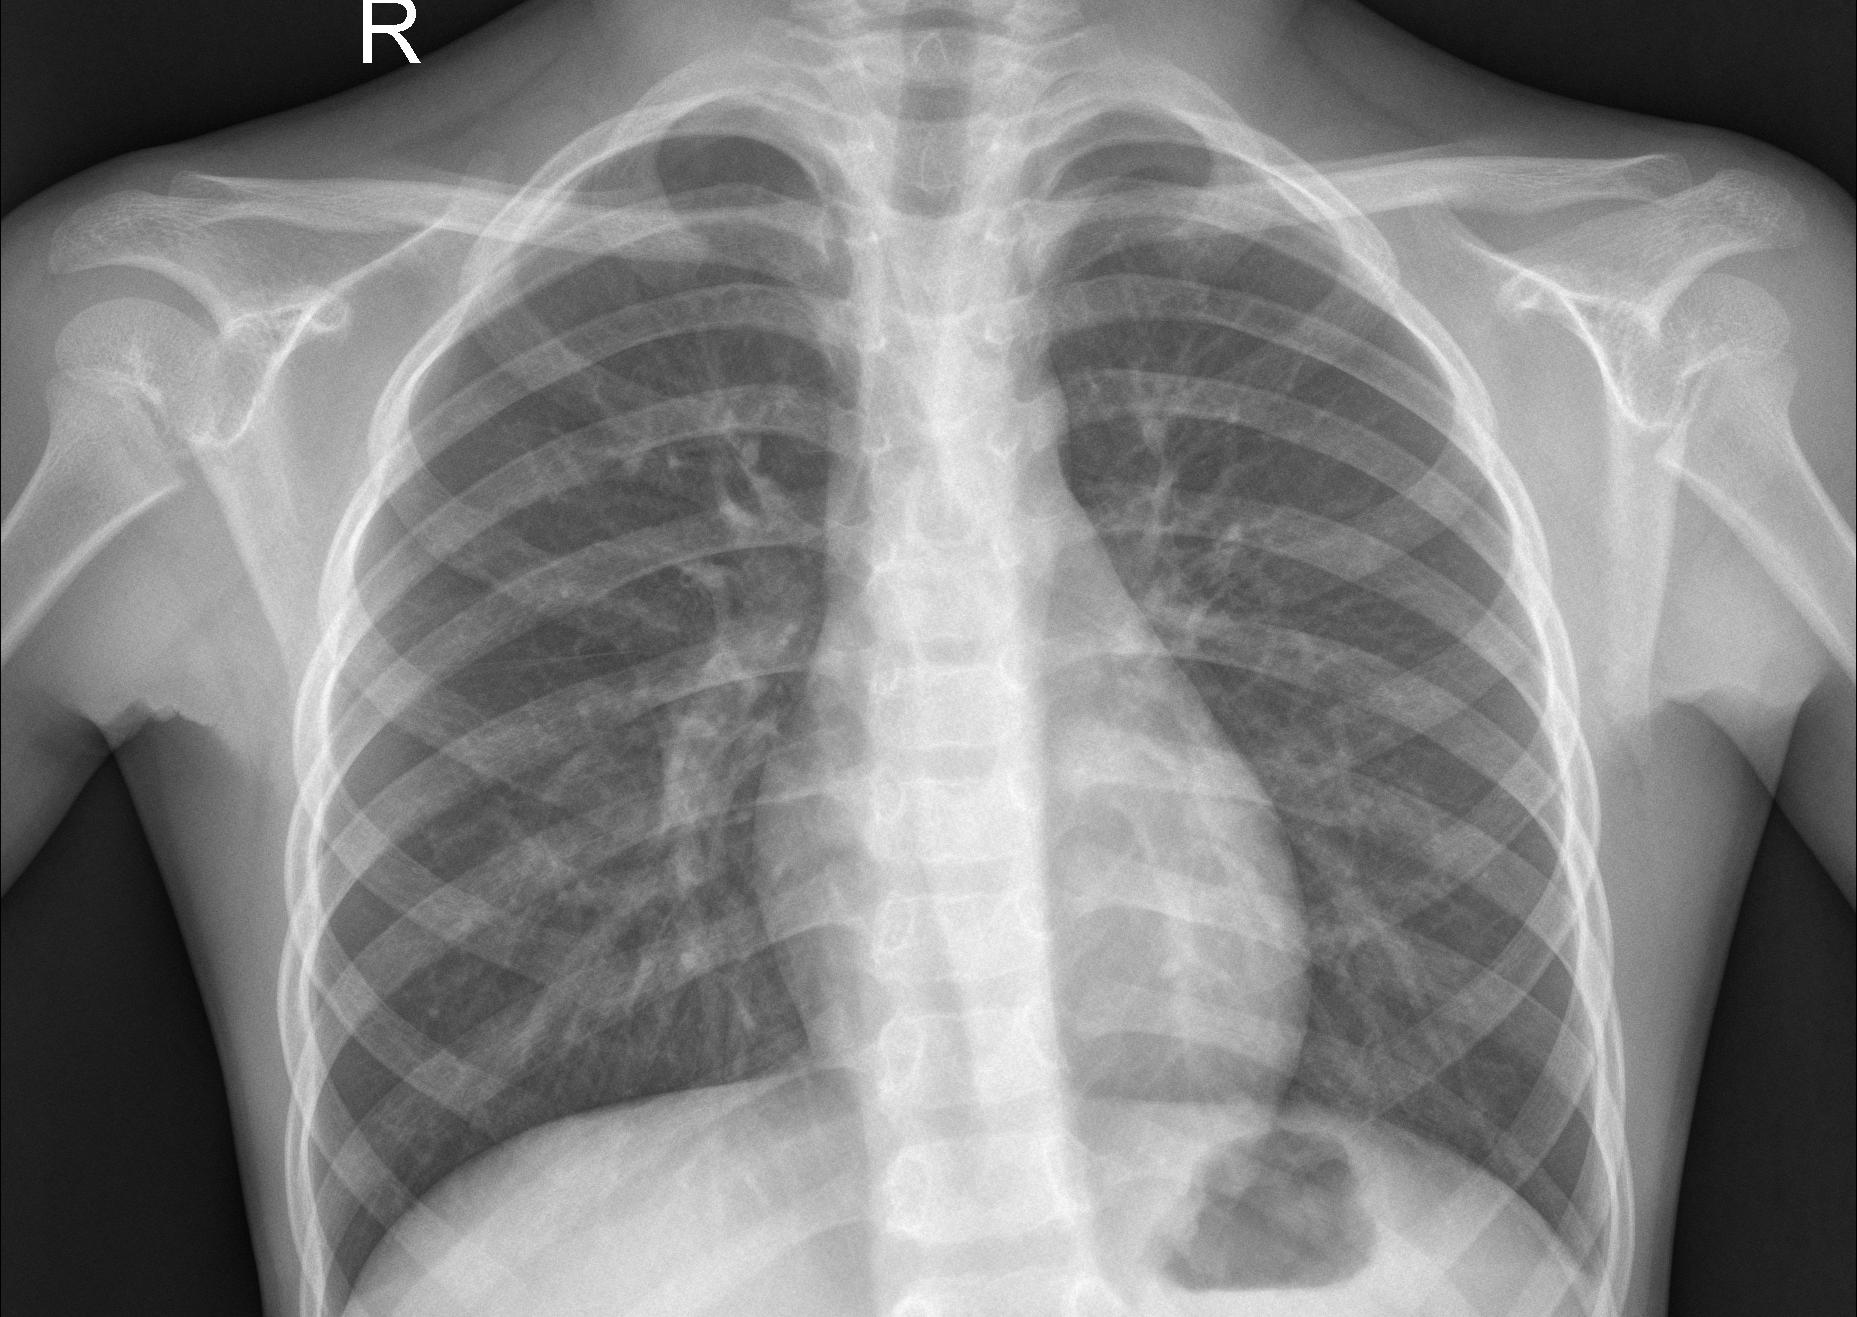

In [24]:
file_name = './chest_xray/test/NORMAL/IM-0001-0001.jpeg'

# test image
from IPython.display import Image
Image(file_name)

In [25]:
# Resize as model was trained after resizing
test_image = load_img(file_name, target_size=(150, 150))
test_image_array = np.array(test_image).reshape((1, 150, 150, 3)).tolist()

# Predict
predictor = Predictor(endpoint_name = "tensorflow-training-2021-05-09-21-58-20-629")
print(predictor.predict({"instances": [{"inputs": test_image_array}]}))


The class sagemaker.tensorflow.serving.Predictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [[0.105284855, 0.89471519]]}
